In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from pathlib import Path
import random

from nilearn import plotting, image, interfaces
from nilearn.image import mean_img
from nilearn.plotting import plot_anat, plot_img, plot_stat_map, show, plot_design_matrix
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.reporting import get_clusters_table
import nilearn
import nibabel as nib
from nilearn.maskers import NiftiMasker

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [4]:
#load data
def load_beta_data():
    
    X, y = [], []
    
    directories = [Path("~/teams/a05/group_1_data/nonConfoundBeta/").expanduser(), 
    Path("~/teams/a05/group_1_data/nonConfoundBeta/betas/").expanduser()]

    for directory in directories:
        
        beta_files = list(directory.glob("beta_*.nii.gz"))

        for file_path in beta_files:
            
            file_name = file_path.stem
            subjID = file_name.split("_")[1]
            task = file_name.split("_")[2]

            beta_img = nib.load(str(file_path))
            beta_data = beta_img.get_fdata().flatten()
            
            X.append(beta_data)
            y.append(task)

    return np.array(X), np.array(y)

X, y = load_beta_data()

In [5]:
def split_train_test_valid(X, y): #split data into 20% test 20% validation 60% training
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) #0.25 * 0.8 = 0.2
    return X_train, X_val, X_test, y_train, y_val, y_test

In [22]:
def KNN(X_train, y_train, X_test, y_test):
    
    model = KNeighborsClassifier(n_neighbors=12)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    return model

In [23]:
X_train, X_val, X_test, y_train, y_val, y_test = split_train_test_valid(X, y)

Model Accuracy: 0.6111


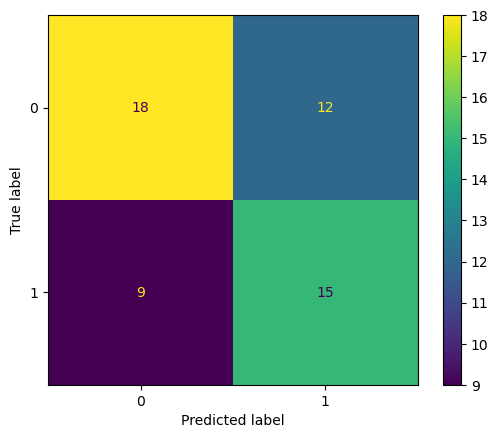

KNeighborsClassifier(n_neighbors=12)

In [24]:
KNN(X_train, y_train, X_val, y_val)

In [2]:
subjects = [103, 105, 106, 109, 110, 115, 117, 124, 
           127, 130, 131, 133, 138, 140, 142, 143, 145,
           147, 157, 159, 161, 165, 172, 176, 177, 178,
           180, 181, 182, 183, 188, 200, 207, 208]
data_type = 'nonConfound'

In [3]:
def load_beta_data_custom_split(subjects, data_type):
    X_train, y_train = [], []
    X_test, y_test = [], []

    mask_img = nilearn.datasets.load_mni152_brain_mask(resolution=2, threshold=0.2)
    masker = NiftiMasker(mask_img=mask_img, memory="nilearn_cache", memory_level=1).fit()

    taskType = ['colorwheel', 'samedifferent']

    for subjID in subjects:
        subject_runs = {}
        for task in taskType:
            runs = []
            for run in range(1, 5): 
                file_path = Path(f"~/teams/a05/group_1_data/{data_type}Beta/beta_{subjID}_{task}_{run}.nii.gz").expanduser()
                if file_path.exists():
                    runs.append((run, file_path))
            
            if len(runs) == 4:
                train_runs = runs[:3]
                test_run = runs[3]

                for run, file_path in train_runs:
                    beta_img = nib.load(str(file_path))
                    # Transform the data using the masker
                    beta_data = masker.transform(beta_img).flatten()
                    X_train.append(beta_data)
                    y_train.append(task)

                run, file_path = test_run
                beta_img = nib.load(str(file_path))
                
                beta_data = masker.transform(beta_img).flatten()
                X_test.append(beta_data)
                y_test.append(task)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), masker

In [4]:
X_train, y_train, X_test, y_test, masker = load_beta_data_custom_split(subjects, data_type)
print(f"Train Samples: {len(X_train)}, Test Samples: {len(X_test)}")

/home/sanarayanan/.local/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images


In [5]:
def KNN(X_train, y_train, X_test, y_test):
    
    model = KNeighborsClassifier(n_neighbors=19)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    return model

Model Accuracy: 0.8358


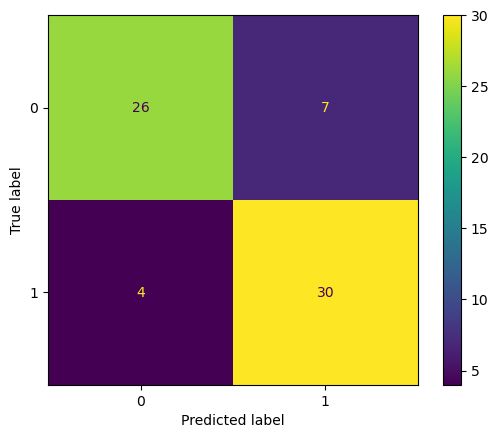

KNeighborsClassifier(n_neighbors=19)

In [6]:
KNN(X_train, y_train, X_test, y_test)